In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
suf = '04_17_23'

with open(f'hists_cutflows_ProcessorV3_{suf}.pickle', 'rb') as file:
    data3 = pickle.load(file)
    

In [3]:

set3 = {
    thing.split('_')[0] + '_' + thing.split('_')[1] + '_' + thing.split('_')[2] 
    for thing in data3.keys()
    if len(thing.split('_')) > 2
}

# intersection = set2.intersection(set3)
intersection = {'PhiToPi0Pi0_mPhi0p3_ctau300', 'PhiToPiPlusPiMinus_mPhi0p3_ctau300'}

data = data3

In [7]:
set3

{'PhiToPi0Pi0_mPhi0p3_ctau300',
 'PhiToPi0Pi0_mPhi1p0_ctau1000',
 'PhiToPiPlusPiMinus_mPhi0p3_ctau300',
 'PhiToPiPlusPiMinus_mPhi1p0_ctau1000',
 'PhiToPiPlusPiMinus_mPhi1p0_ctau300'}

In [8]:
intersection

{'PhiToPi0Pi0_mPhi0p3_ctau300', 'PhiToPiPlusPiMinus_mPhi0p3_ctau300'}

In [4]:
for sample in intersection:
    print(f"nEvents: {data3[sample]['numEvents_pretrigger']}")

print(data3['background']['numEvents_pretrigger'])

nEvents: 1529039
nEvents: 1541579
25667521


In [5]:
nEvents = {
    dataset:{
        cut[10:]: data[dataset][cut]
        for cut in data[dataset]
        if 'numEvents' in cut 
        and cut[-2:] != 'SF'
    }
    for dataset in data
    if dataset[-4:] not in ['vars','cuts']             
}

muon_SFs = {
            dataset[:-5]:{
                cut[12:]: data[dataset][cut]
                for cut in data[dataset]
                if 'muonSF' in cut 
            }
            for dataset in data
            if dataset[-4:] == 'vars'
        }


genfiltereff = {
    'PhiToPiPlusPiMinus_mPhi0p3_ctau1000': 0.2140541025727333, 
    'PhiToPiPlusPiMinus_mPhi0p3_ctau300': 0.2919021657580153, 
    'PhiToPi0Pi0_mPhi0p3_ctau300': 0.2913132061492869, 
    'PhiToPi0Pi0_mPhi0p3_ctau1000': 0.2133676092544987, 
    #'background': 1,
}




gllp_ctaus = {
    dataset[:-5]:{
        cut[15:]: data[dataset][cut]
        for cut in data[dataset]
        if 'gLLP_ctau' in cut 
    }
    for dataset in data
    if dataset[-4:] == 'vars'
}

gllp_limit = {
    dataset[:-5]:{}
    for dataset in data
    if dataset[-4:] == 'vars'
}

In [7]:
muonfiltereff = 0.00514
xsec = 472.8e9/4e-1
lumi = 41.6

N_bb = 5e9
N_bb_p = .02

for dataset in intersection:
        num_cut = 'mb1_adjacent'

        # dem_cut = 'posttrigger'
        dem_cut = 'eventHLT_cut'

        if 'ctau1000' in dataset:
            old_ctau = 100
        if 'ctau300' in dataset:
            old_ctau = 30

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        ctau_list = np.logspace(-.3, 4, 50)
        new_nEvents = np.zeros_like(ctau_list)

        gLLP_ctau = np.array(gllp_ctaus[dataset][num_cut])

        
        muon_SF = np.array(muon_SFs[dataset][num_cut])
        for i, new_ctau in enumerate(ctau_list):
            weight_terms = (old_ctau/new_ctau) * np.exp(gLLP_ctau*(1/old_ctau - 1/new_ctau))
            weight_terms *= muon_SF #this applies the scale factor corrections
            weight = np.sum(weight_terms)
            new_nEvents[i] = weight

        N_sig = muonfiltereff * genfiltereff[dataset] * new_nEvents * xsec * lumi / nEvents[dataset][dem_cut]
                
        N_bkg = N_bb_p * N_bb * nEvents['background'][num_cut]/nEvents['background'][dem_cut] 
        
        BR = 2 * np.sqrt(N_bkg)/N_sig

        gllp_limit[dataset]['BR'] = BR
        gllp_limit[dataset]['ctau_list'] = ctau_list
        gllp_limit[dataset]['new_nEvents'] = new_nEvents
        gllp_limit[dataset]['N_sig'] = N_sig
        gllp_limit[dataset]['N_bkg'] = N_bkg


In [33]:
sys = 'DT'
dataset = 'PhiToPi0Pi0_mPhi0p3_ctau300'
i = 23

ctau = gllp_limit[dataset]['ctau_list'][i]
norm = 1e8
sig = gllp_limit[dataset]['N_sig'][i]
bkg = gllp_limit[dataset]['N_bkg']
width = 10


print(f"""
# system {sys}
# dataset {dataset}
# ctau {ctau} cm
# norm {norm}
# sig {sig}
# bkg {bkg}
imax 1
jmax 1
kmax *
------------------------------------------------
------------------------------------------------
bin          {'bin1':<{width}}
observation  {bkg:<{width}}
------------------------------------------------
bin          {'bin1':<{width}} {'bin1':<{width}}
process      {'0':<{width}} {'1':<{width}}
process      {'sig':<{width}} {'bkg':<{width}}
rate         {sig/norm:<{width}} {bkg:<{width}}
------------------------------------------------
""")


# system DT
# dataset PhiToPi0Pi0_mPhi0p3_ctau300
# ctau 52.28382434830956 cm
# norm 100000000.0
# sig 357259712.1795809
# bkg 18098.98415651497
imax 1
jmax 1
kmax *
------------------------------------------------
------------------------------------------------
bin          bin1      
observation  18098.98415651497
------------------------------------------------
bin          bin1       bin1      
process      0          1         
process      sig        bkg       
rate         3.5725971217958095 18098.98415651497
------------------------------------------------



In [8]:
for thing in intersection:
    print(f"{thing}: {gllp_limit[dataset]['N_bkg']}")

PhiToPiPlusPiMinus_mPhi0p3_ctau300: 18098.98415651497
PhiToPi0Pi0_mPhi0p3_ctau300: 18098.98415651497


# print out table for daniel

In [11]:
dataset = 'PhiToPi0Pi0_mPhi0p3_ctau300'
print(np.array([gllp_limit[dataset]['ctau_list'],gllp_limit[dataset]['BR']]).T)

[[5.01187234e-01 1.62117279e-04]
 [6.13416003e-01 9.04961363e-05]
 [7.50775694e-01 5.30506276e-05]
 [9.18893768e-01 3.21254201e-05]
 [1.12465782e+00 2.00051725e-05]
 [1.37649776e+00 1.28290545e-05]
 [1.68473117e+00 8.49307545e-06]
 [2.06198601e+00 5.81160059e-06]
 [2.52371795e+00 4.10997792e-06]
 [3.08884360e+00 3.00139790e-06]
 [3.78051548e+00 2.26107764e-06]
 [4.62707056e+00 1.75582466e-06]
 [5.66319120e+00 1.40488071e-06]
 [6.93132602e+00 1.15805629e-06]
 [8.48342898e+00 9.83370014e-07]
 [1.03830879e+01 8.59977857e-07]
 [1.27081295e+01 7.74084524e-07]
 [1.55538080e+01 7.16527772e-07]
 [1.90367075e+01 6.81288981e-07]
 [2.32995181e+01 6.64531921e-07]
 [2.85168821e+01 6.63977756e-07]
 [3.49025488e+01 6.78519088e-07]
 [4.27181312e+01 7.08004517e-07]
 [5.22838243e+01 7.53135383e-07]
 [6.39915234e+01 8.15432232e-07]
 [7.83208787e+01 8.97249001e-07]
 [9.58589468e+01 1.00182908e-06]
 [1.17324241e+02 1.13340560e-06]
 [1.43596170e+02 1.29735087e-06]
 [1.75751062e+02 1.50038045e-06]
 [2.151062

In [12]:
def plotter(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit[thing]['ctau_list'], gllp_limit[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit')
    # ax.set_xlim(5e-1,1e4)
    # ax.set_ylim(1e-6,1e-1)
    ax.legend()
    ax.grid(which='both')
    ax.set_title("Aram's")
    
def plotter2(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit2[thing]['ctau_list'], gllp_limit2[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit')
    # ax.set_xlim(5e-1,1e4)
    # ax.set_ylim(1e-6,1e-1)
    ax.legend()
    ax.grid(which='both')
    ax.set_title("Christina's")

NameError: name 'gllp_limit2' is not defined

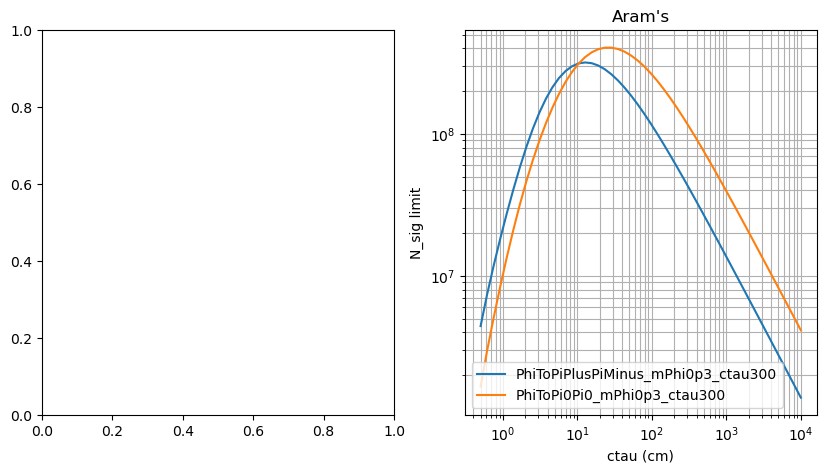

In [13]:
a = 5
fig, axes = plt.subplots(1,2, figsize = (2*a, a))
plotter('N_sig', axes[1], intersection)
plotter2('N_sig', axes[0], intersection)


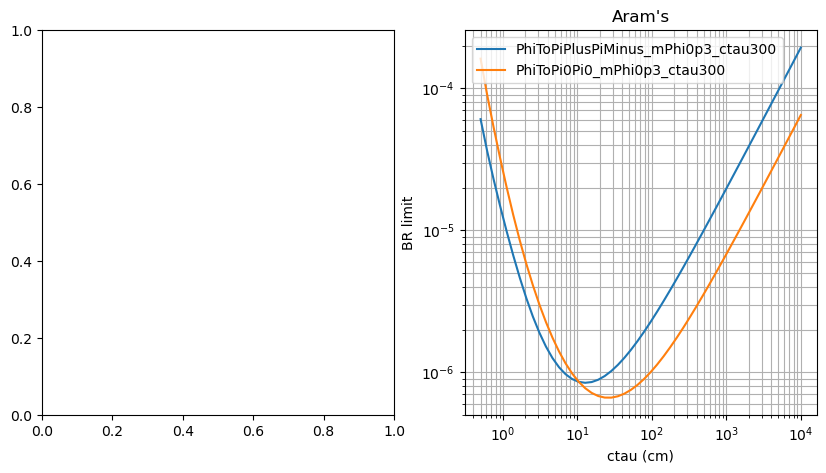

In [15]:
a = 5
fig, axes = plt.subplots(1,2, figsize = (2*a, a))
plotter('BR', axes[1], intersection)


In [18]:
def ratio_plotter(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit[thing]['ctau_list'], gllp_limit2[thing][y_axis]/gllp_limit[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit ratio')

    ax.legend()
    ax.grid(which='both')
    ax.set_title("Christina's/Aram's")

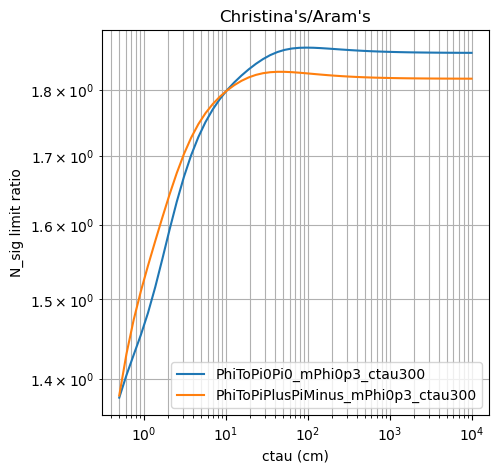

In [19]:
a = 5
fig, axes = plt.subplots(1,1, figsize = (a, a))
ratio_plotter('N_sig', axes, intersection)

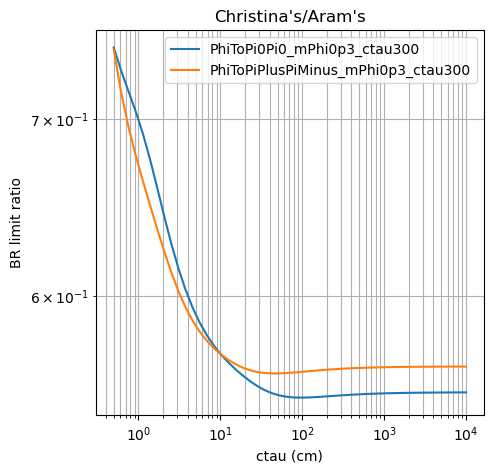

In [20]:
a = 5
fig, axes = plt.subplots(1,1, figsize = (a, a))
ratio_plotter('BR', axes, intersection)

In [27]:
[(thing, data3['background'][thing]) for thing in data3['background'] if 'numEvents' in thing]

[('numEvents_pretrigger', 25667521),
 ('numEvents_pretrigger_SF', 25667521),
 ('numEvents_|muonId| == 13', 25667155),
 ('numEvents_|muonEta| < 1.5', 24447118),
 ('numEvents_muonPt > 7', 23811521),
 ('numEvents_muonHLTReq', 22896397),
 ('numEvents_muonQual >= 2^25', 22039911),
 ('numEvents_muonLeadPtReq', 22039911),
 ('numEvents_posttrigger', 22039911),
 ('numEvents_llp_acc', 22039911),
 ('numEvents_num Cluster > 0', 5032009),
 ('numEvents_dR_gllp_cls < .4', 5032009),
 ('numEvents_dR_lmuon_cls > .8', 3636833),
 ('numEvents_ME1112_veto', 225213),
 ('numEvents_re12_veto', 223152),
 ('numEvents_mb1_veto', 221278),
 ('numEvents_rb1_veto', 220283),
 ('numEvents_muon_veto_pt < 20', 219472),
 ('numEvents_-5 < cls_time < 12.5', 37357),
 ('numEvents_|cls_timeSpread| < 20', 25559),
 ('numEvents_|cls_eta| < 1.9', 4710),
 ('numEvents_cut_based_ID', 2530),
 ('numEvents_cls_size > 130', 97)]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff0a2f93ad0>, errorbar=None, legend_artist=None)]

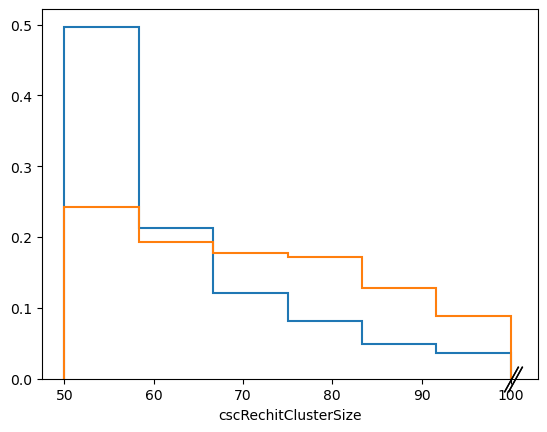

In [22]:
import mplhep as hep

hep.histplot(data3['background']['cscRechitClusterSize with cut_based_ID']/sum(data3['background']['cscRechitClusterSize with cut_based_ID']))
hep.histplot(data3['PhiToPi0Pi0_mPhi0p3_ctau300']['cscRechitClusterSize with cut_based_ID']/sum(data3['PhiToPi0Pi0_mPhi0p3_ctau300']['cscRechitClusterSize with cut_based_ID']))